# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 07/23/2024 by AFS

In [1]:
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.stats import zscore
# import time 
import datetime 
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# keep this so we can use our respective paths for testing
current_user = 'christina'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

07232024


In [4]:
if current_user == 'christina':
    base_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/scripts/'
    data_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/'
    tfr_dir  = f'{data_dir}tfr/'
    anat_dir = f'{data_dir}anat/'
elif current_user == 'alie':
    # base_dir = '/hpc/users/finka03/NeuroCluster/NeuroCluster/'
    # swb_dir  = '/sc/arion/projects/guLab/Alie/SWB/'
    # tfr_dir  = f'{swb_dir}ephys_analysis/data/'
    # beh_dir  = f'{swb_dir}swb_behav_models/data/behavior_preprocessed/'
    # anat_dir = f'{swb_dir}ephys_analysis/recon_labels/'
    # save_dir = f'{base_dir}/data/'
    
    base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/scripts/'
    data_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
    tfr_dir  = f'{data_dir}ephys_analysis/data/'
    beh_dir  = f'{data_dir}behavior_analysis/behavior_preprocessed/'
    anat_dir = f'{data_dir}anat_recons/'

In [174]:
# load functions 
import sys
sys.path.append(f'{base_dir}')
# sys.path.append(f'{base_dir}scripts/')

from tfr_cluster_test import *
from helper_utils import *
from plotting_utils import * 

# Step 1: Format Input Data (Currently within-subject)
- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [12]:
# load epoched data for single subj
if current_user == 'alie':
    permute_var = 'decisionCPE'
    subj_id     = 'MS002'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
elif current_user == 'christina':
    permute_var = 'expected_value'
    subj_id     = 'MS009'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}_tfr.h5')[0]

Reading /Users/christinamaher/Documents/GitHub/NeuroCluster/tfr/MS009_tfr.h5 ...
Adding metadata with 6 columns


In [13]:
# temp just for CMM data 

# add ev_zscore to power_epochs metadata
behavior = pd.read_csv('/Users/christinamaher/Desktop/old_preprocess/MS009/MS009_clean.csv')

# add ev_zscore to the power_epochs metadata 
power_epochs.metadata['ev_zscore'] = behavior['expected_value'].values

# drop trials == no_hint from power_epochs
power_epochs = power_epochs["condition == 'hint'"]

In [14]:
# set ROI for single ROI anaylsis 
if current_user == 'alie':
#     roi = 'ains'
    # set all variables included mutliple regression 
    multi_reg_vars = ['GambleChoice','TrialEV','decisionCPE']
    # set main variable of interest for permutations 
    permute_var = 'decisionCPE'
    # load subj behavior data 
#     beh_df = pd.read_csv(f'{beh_dir}{subj_id}_task_data')
    beh_df = power_epochs.metadata.copy()
    # beh_df['subj_id'] = subj_id
    # add TrialEV to df
    beh_df['TrialEV'] = beh_df.GambleEV - beh_df.SafeBet
    # clean subj dataframe from fail trials/nan values in vars of interest     
    # beh_df = beh_df[(beh_df.GambleChoice=='gamble')|(beh_df.GambleChoice=='safe')]
#     beh_df = beh_df[(beh_df.Outcome=='good')|(beh_df.Outcome=='bad')]
    
    # zscore continuous variables 
    beh_df[multi_reg_vars[1:]] = pd.DataFrame({f'{var}':zscore(beh_df[var])  for var in multi_reg_vars[1:]})
    # format final beh_df
    beh_df = beh_df[multi_reg_vars].reset_index(drop=True) 
    # convert choice to categorical variable
    beh_df['GambleChoice'] = beh_df['GambleChoice'].astype('category')

elif current_user == 'christina':
    beh_df = prepare_regressor_df(power_epochs)
    # assign column names for to multi_reg_vars list
    multi_reg_vars = beh_df.columns.tolist()
    ## new function for getting elecs in ROI
    roi = ['lpfc','ofc']
    roi_subj_elecs = prepare_anat_dic(roi, f'{anat_dir}master_labels.csv')
    roi_subj_elecs


In [15]:
#### class TFR_Cluster_Test dev + debugging

if current_user == 'alie':

    # subset single electrode tfr data + behav data
    dev_ch_idx     = power_epochs.ch_names.index('laims2-laims3')
    ch_name        = 'laims2-laims3'
    tfr_data       = np.squeeze(power_epochs._data[:,dev_ch_idx,:,:].copy())
    predictor_data = beh_df.copy()
    
    # predictor_data = predictor_data.drop(columns='subj_id')

elif current_user == 'christina':
    
        # subset single electrode tfr data + behav data
        # predictor_data = predictor_data.drop(columns=['condition','chosen_shape_current_trial','chosen_color_current_trial','chosen_shape_previous_trial','chosen_color_previous_trial','ev'])
        tfr_data = np.squeeze(power_epochs._data[:,0,:,:].copy())
        ch_name = power_epochs.info['ch_names'][0]
        predictor_data = beh_df.copy()

In [16]:
# drop nan values from predictor data
predictor_data = predictor_data.dropna()
predictor_data

,rd,r,ev_zscore
36,shape,1,0.166667
37,shape,0,0.304334
38,shape,1,0.166666
39,shape,1,0.304335
40,shape,1,0.419259
...,...,...,...
211,color,1,0.781656
212,color,1,0.817726
213,color,0,0.847838
214,color,1,0.707775


## Step 2: Find Real Clusters
- Use TFRClusterTest class code to run multivariate regression
- Allows for multiple regression implementation and pixel paralellization, so with more speed improvements will ultimately be worth it.

In [18]:
permute_var = 'ev_zscore'
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')
cluster_test

In [19]:
betas, tstats = cluster_test.tfr_regression()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 42968 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    4.2s finished


In [20]:
tstats

array([[-1.17468095, -1.18797488, -1.20150434, ..., -2.18077116,
        -2.17789314, -2.17491742],
       [-1.26160309, -1.27314928, -1.28487812, ..., -1.88617688,
        -1.88055175, -1.8750149 ],
       [-1.38549875, -1.39262364, -1.39987974, ..., -1.40210248,
        -1.40792288, -1.41390276],
       ...,
       [-0.62302808, -0.49697702, -0.46137801, ..., -0.6401826 ,
        -0.68251559, -0.75881873],
       [ 0.31276651, -0.08377359, -0.50590195, ...,  0.60456023,
         0.54167589,  0.46277499],
       [ 0.91402539,  0.5231472 ,  0.08411767, ...,  0.17151176,
         0.30293207,  0.44100787]])

In [49]:
beh_variables = cluster_test.predictor_data.columns.tolist().copy()
control_variables = [var for var in beh_variables if var != cluster_test.permute_var] 

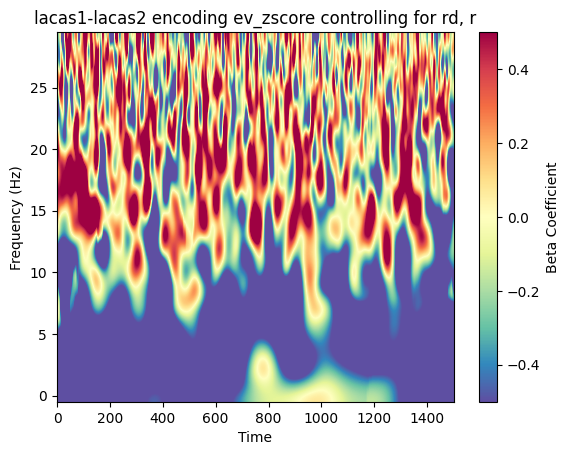

In [53]:
def plot_beta_coef(betas, cluster_test):

    plt.imshow(betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
    cbar = plt.colorbar()
    cbar.set_label('Beta Coefficient')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (ms)')

    # make title dynamic depending on whether or not you are controlling for other variables
    if cluster_test.predictor_data.columns.tolist() == [cluster_test.permute_var]:
        plt.title(f'{cluster_test.ch_name} encoding {cluster_test.permute_var}')
    else:
        beh_variables = cluster_test.predictor_data.columns.tolist().copy()
        control_variables = [var for var in beh_variables if var != cluster_test.permute_var] 
        control_variables_str = ", ".join(control_variables)
        plt.title(f'{cluster_test.ch_name} encoding {cluster_test.permute_var} controlling for {control_variables_str}')
    plt.show()

plot_beta_coef(betas, cluster_test)

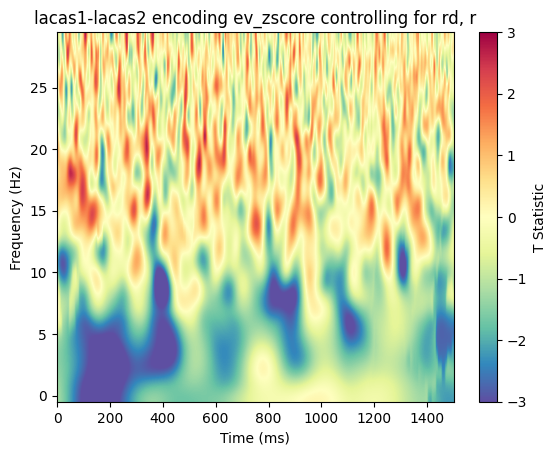

In [56]:
def plot_tstats(tstats, cluster_test):

    plt.imshow(tstats, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-3,vmax=3) 
    cbar = plt.colorbar()
    cbar.set_label('T Statistic')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (ms)')
    # make title dynamic depending on whether or not you are controlling for other variables
    if cluster_test.predictor_data.columns.tolist() == [cluster_test.permute_var]:
        plt.title(f'{cluster_test.ch_name} encoding {cluster_test.permute_var}')
    else:
        beh_variables = cluster_test.predictor_data.columns.tolist().copy()
        control_variables = [var for var in beh_variables if var != cluster_test.permute_var] 
        control_variables_str = ", ".join(control_variables)
        plt.title(f'{cluster_test.ch_name} encoding {cluster_test.permute_var} controlling for {control_variables_str}')
    plt.show()

plot_tstats(tstats, cluster_test)

In [61]:
def plot_tstat_threshold():

    plt.imshow(cluster_test.tstat_threshold, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-3,vmax=3) 
    cbar = plt.colorbar()
    cbar.set_label('T Statistic Threshold')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (ms)')
    plt.title('T Statistic Threshold')
    plt.show()


AttributeError: 'TFR_Cluster_Test' object has no attribute 'tstat_threshold'

In [85]:
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats,alternative ='two-sided')
isinstance(tstat_threshold, list)

True

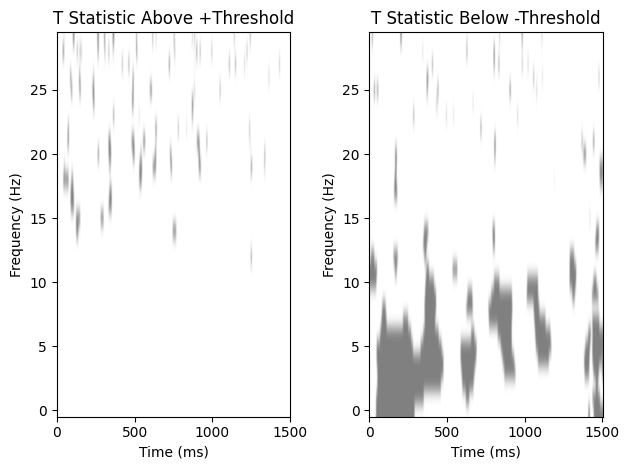

In [90]:
plot_tstat_threshold(cluster_test.threshold_tfr_tstat(tstats,alternative ='two-sided'),alternative ='two-sided')

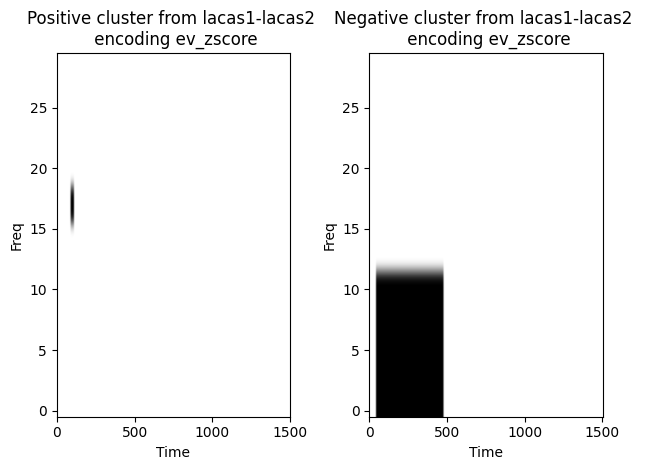

In [113]:
plot_max_clusters(max_cluster_data, tstats, cluster_test)

## Step 3: Compute Null Cluster Distribution from Permutations

In [26]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

In [118]:
null_cluster_distribution

[[579.9318063680416,
  874.5883340627438,
  360.47355798125665,
  175.22145718219252,
  244.71762714203294,
  1252.5734810846147,
  573.0931955701616,
  524.6433458435343,
  117.18319023885974,
  302.6970940975805],
 [-1363.876187231273,
  -350.15808283565025,
  -253.7021628526787,
  -706.0153470233302,
  -4484.287830905368,
  -183.75872749747026,
  -517.2948115100663,
  -228.60080558563314,
  -1448.2466570713013,
  -910.6788007240735]]

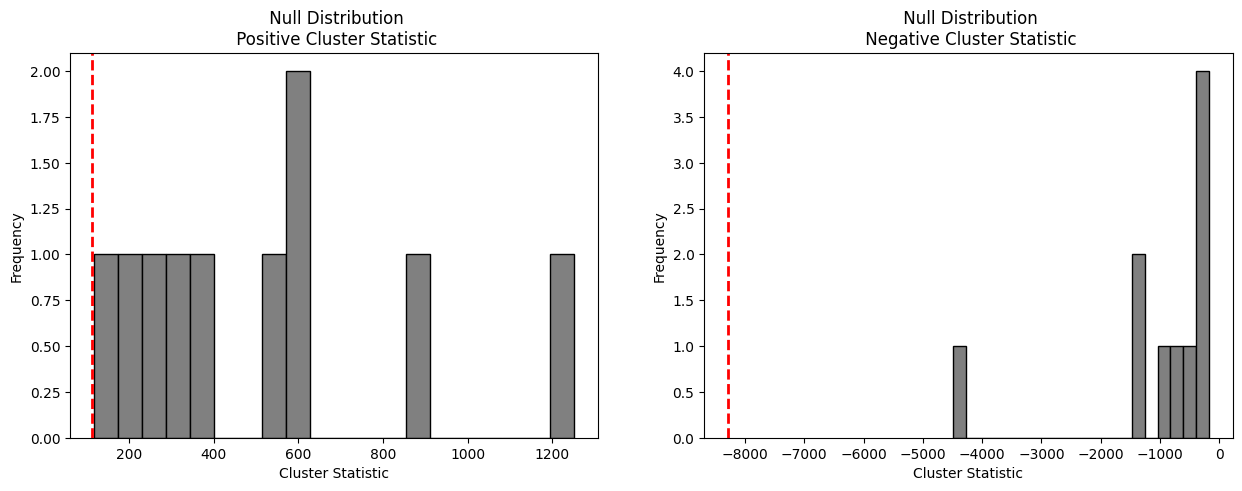

In [123]:
plot_null_distribution(null_cluster_distribution, max_cluster_data)

In [ ]:
np.mean(null_cluster_distribution[1])

In [ ]:
null_cluster_distribution

In [ ]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) #compute_cluster_pvalue cluster_significance_test


In [ ]:
cluster_pvalue

#### POLISHED WORKFLOW

In [ ]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR
betas, tstats = cluster_test.tfr_regression()

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution,alpha=0.05) #compute_cluster_pvalue cluster_significance_test



#### POLISHED PLOTTING 

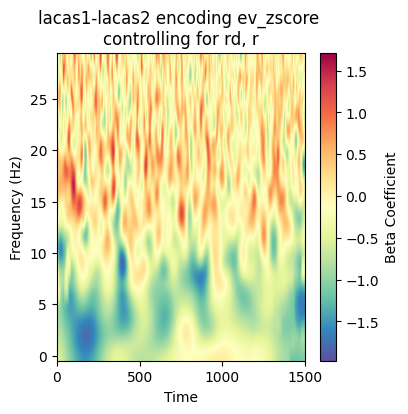

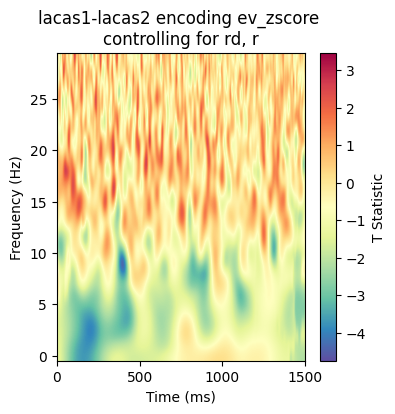

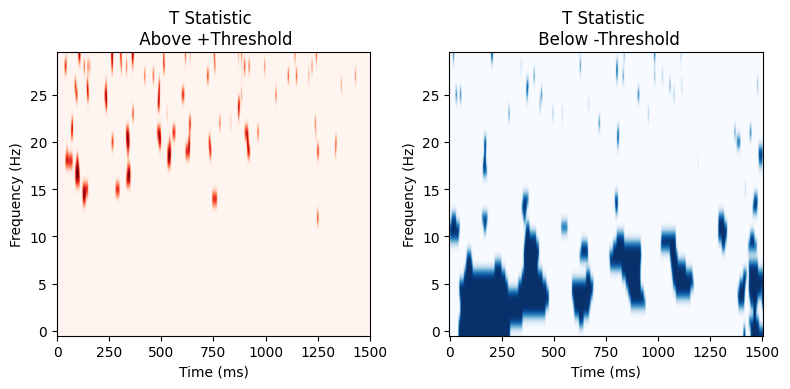

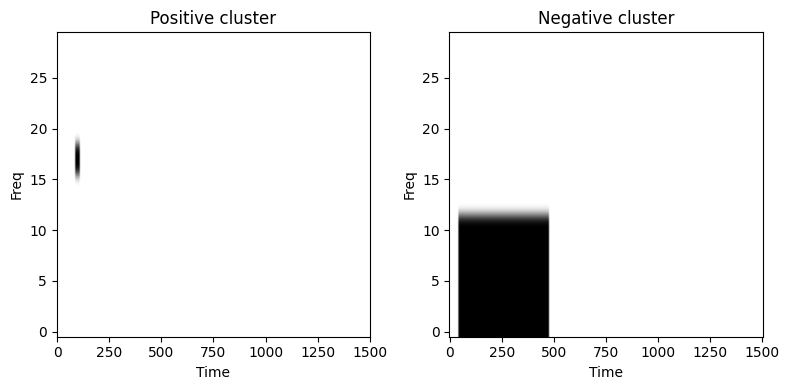

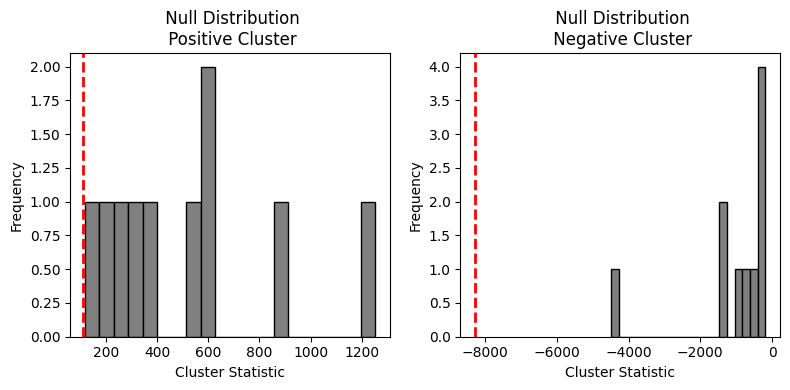

(None, None, None, None, None)

In [180]:
plot_neurocluster_results(betas,cluster_test, max_cluster_data, null_cluster_distribution, tstats, tstat_threshold)


In [ ]:
# To implement FDR correction: 
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
# multitest.multipletests(p_upper, method='fdr_bh')